In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime
import string
from scipy import interpolate
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.stats import gamma
from scipy.stats import norm
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity as KD
from sklearn.linear_model import LinearRegression

os.chdir("C:\\Users\\Lenovo\\Desktop\\Warsztaty z ML\\Projekt\\Dane")



In [2]:
#tworzy z timestampa czas w sekundach od benchmark date
benchmark_date = pd.to_datetime("2016-01-01 00:00:00",format="%Y-%m-%d %H:%M:%S")
def clean_timestamp(x,benchmark_date):
	y=x.replace("T"," ")
	y=y.replace("+00:00","")
	y=pd.to_datetime(y,format="%Y-%m-%d %H:%M:%S")
	y=(y-benchmark_date).total_seconds()
	return y

In [3]:
#AJ: prosze mi wyslac ten plik, albo skrypt ktory go generowal!!!
failures = pd.read_csv("wind-farm-1-failures-training.csv",sep=";")
failures["time"]=failures.Timestamp.apply(lambda x:clean_timestamp(x,benchmark_date))
failures["period"]=failures.time.apply(lambda x:int(np.floor(x/600)))

In [4]:
metmast = pd.read_csv("wind-farm-1-metmast-training.csv",sep=";")
metmast["time"] = metmast.Timestamp.apply(lambda x:clean_timestamp(x,benchmark_date))
metmast["period"] = metmast.time.apply(lambda x:int(np.floor(x/600)))

In [5]:
signals = pd.read_csv("wind-farm-1-signals-training.csv",sep=";")
signals["time"] = signals.Timestamp.apply(lambda x:clean_timestamp(x,benchmark_date))
signals["period"] = signals.time.apply(lambda x:int(np.floor(x/600)))

In [6]:
signals_T11=signals.loc[signals.Turbine_ID=="T11"].reset_index(drop=True)

signals_T06=signals.loc[signals.Turbine_ID=="T06"].reset_index(drop=True)

signals_T07=signals.loc[signals.Turbine_ID=="T07"].reset_index(drop=True)

signals_T01=signals.loc[signals.Turbine_ID=="T01"].reset_index(drop=True)

signals_T09=signals.loc[signals.Turbine_ID=="T09"].reset_index(drop=True)

In [7]:
merged=signals.merge(metmast,on=["period"])

In [8]:
merged["angle_difference"]=(merged["Nac_Direction_Avg"]-merged["Avg_Winddirection2"])%360
merged["angle"]=pd.DataFrame({"a":abs(180-merged["angle_difference"]),
              "b":(-merged["angle_difference"])%360,
              "c":merged["angle_difference"]}).apply(np.min,1)

In [9]:
merged["cos"]=np.cos(np.pi*merged["angle"]/180)

In [10]:
merged["sin"]=np.sin(np.pi*merged["angle"]/180)

In [11]:
merged=merged.merge(failures[["Turbine_ID","period","time"]],how="left",on=["Turbine_ID","period"])

In [12]:
merged_T11=merged.loc[merged.Turbine_ID=="T11"].reset_index(drop=True)

merged_T06=merged.loc[merged.Turbine_ID=="T06"].reset_index(drop=True)

merged_T07=merged.loc[merged.Turbine_ID=="T07"].reset_index(drop=True)

merged_T01=merged.loc[merged.Turbine_ID=="T01"].reset_index(drop=True)

merged_T09=merged.loc[merged.Turbine_ID=="T09"].reset_index(drop=True)

Mamy w tym momencie ramkę danych o każdej turbinie zmergowaną z awariami oraz pogodą. Tworzymy nową zmienną czas do awarii.

In [13]:
czas=-1
for i in range(len(merged_T11["time"])):
    if not np.isnan(merged_T11.loc[len(merged_T11["time"])-i-1,"time"]):
        czas=merged_T11.loc[len(merged_T11["time"])-i-1,"time"]
    merged_T11.loc[len(merged_T11["time"])-i-1,"time"]=czas

In [14]:
czas=-1
for i in range(len(merged_T06["time"])):
    if not np.isnan(merged_T06.loc[len(merged_T06["time"])-i-1,"time"]):
        czas=merged_T06.loc[len(merged_T06["time"])-i-1,"time"]
    merged_T06.loc[len(merged_T06["time"])-i-1,"time"]=czas

In [15]:
czas=-1
for i in range(len(merged_T07["time"])):
    if not np.isnan(merged_T07.loc[len(merged_T07["time"])-i-1,"time"]):
        czas=merged_T07.loc[len(merged_T07["time"])-i-1,"time"]
    merged_T07.loc[len(merged_T07["time"])-i-1,"time"]=czas

In [16]:
czas=-1
for i in range(len(merged_T01["time"])):
    if not np.isnan(merged_T01.loc[len(merged_T01["time"])-i-1,"time"]):
        czas=merged_T01.loc[len(merged_T01["time"])-i-1,"time"]
    merged_T01.loc[len(merged_T01["time"])-i-1,"time"]=czas

In [17]:
czas=-1
for i in range(len(merged_T09["time"])):
    if not np.isnan(merged_T09.loc[len(merged_T09["time"])-i-1,"time"]):
        czas=merged_T09.loc[len(merged_T09["time"])-i-1,"time"]
    merged_T09.loc[len(merged_T09["time"])-i-1,"time"]=czas

In [18]:
df = pd.concat([merged_T11,merged_T06,merged_T07,merged_T01,merged_T09]).reset_index(drop=True)

In [19]:
df["time_to_failure"]=df["time"]-df["time_x"]
df=df.loc[df["time_to_failure"]>0,:].reset_index(drop=True)

In [20]:
df["time_to_failure"]=df["time_to_failure"]/600

Czas do awarii będzie tutaj podany w jednostkach 10min

In [21]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283485 entries, 0 to 283484
Data columns (total 133 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Turbine_ID                   283485 non-null  object 
 1   Timestamp_x                  283485 non-null  object 
 2   Gen_RPM_Max                  283485 non-null  float64
 3   Gen_RPM_Min                  283485 non-null  float64
 4   Gen_RPM_Avg                  283485 non-null  float64
 5   Gen_RPM_Std                  283485 non-null  float64
 6   Gen_Bear_Temp_Avg            283483 non-null  float64
 7   Gen_Phase1_Temp_Avg          283485 non-null  int64  
 8   Gen_Phase2_Temp_Avg          283485 non-null  int64  
 9   Gen_Phase3_Temp_Avg          283485 non-null  int64  
 10  Hyd_Oil_Temp_Avg             283485 non-null  int64  
 11  Gear_Oil_Temp_Avg            283485 non-null  int64  
 12  Gear_Bear_Temp_Avg           283485 non-null  int64  
 13

Usuwamy jakieś wiersze na brakami danych oraz takie z ujemną produkcją prądu, bo sensu większego nie mają.

In [22]:
df=df.dropna()

In [23]:
df=df.loc[df["Grd_Prod_Pwr_Avg"]>0,].reset_index(drop=True)

In [24]:
Y=df["time_to_failure"]

In [25]:
X=df.drop(columns=["Turbine_ID","Timestamp_x","time_x","period","Timestamp_y","time_y","time"])

Funkcja do przycinania tabelki zgodnie z wartościami wiatru które chcemy obserwować.

In [26]:
def trim_wind(turbine, lower, uper):
    return turbine.loc[(turbine["Amb_WindSpeed_Avg"] < uper) & (turbine["Amb_WindSpeed_Avg"] > lower) , :]

Wczytujemy power curve i interpolujemy ją, żeby dało się ją zrobić ciągłą.

In [27]:
Power_curve = pd.read_csv('Power_curve.csv').set_index('Wind speed (m/s)')
power_curve2 = interpolate.interp1d(Power_curve.index, Power_curve.iloc[:,0])

Funkcja do standaryzowania mocy przy pomocy power curve.

In [28]:
def std_power_curve2(turbine):
    turbine_new = turbine.copy()
    turbine_new = trim_wind(turbine, 4, 15)
    turbine_new["Pwr_Std"] = turbine_new["Grd_Prod_Pwr_Avg"] - power_curve2(turbine_new["Amb_WindSpeed_Avg"])
    return turbine_new

In [29]:
X.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194471 entries, 0 to 194470
Data columns (total 126 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Gen_RPM_Max                  194471 non-null  float64
 1   Gen_RPM_Min                  194471 non-null  float64
 2   Gen_RPM_Avg                  194471 non-null  float64
 3   Gen_RPM_Std                  194471 non-null  float64
 4   Gen_Bear_Temp_Avg            194471 non-null  float64
 5   Gen_Phase1_Temp_Avg          194471 non-null  int64  
 6   Gen_Phase2_Temp_Avg          194471 non-null  int64  
 7   Gen_Phase3_Temp_Avg          194471 non-null  int64  
 8   Hyd_Oil_Temp_Avg             194471 non-null  int64  
 9   Gear_Oil_Temp_Avg            194471 non-null  int64  
 10  Gear_Bear_Temp_Avg           194471 non-null  int64  
 11  Nac_Temp_Avg                 194471 non-null  int64  
 12  Rtr_RPM_Max                  194471 non-null  float64
 13

Zostawiamy tylko potrzebne zmienne.

In [30]:
X=df[["Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg","angle_difference","time_to_failure"]]

In [31]:
X=std_power_curve2(X)

<ipython-input-28-85303a3b4c4c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  turbine_new["Pwr_Std"] = turbine_new["Grd_Prod_Pwr_Avg"] - power_curve2(turbine_new["Amb_WindSpeed_Avg"])


Zostawiamy sobie zmienną objaśnianą jako oddzielny Y.

In [32]:
Y=X["time_to_failure"]

In [33]:
X=X.drop(columns=["time_to_failure"])

In [34]:
X.head()

,Grd_Prod_Pwr_Avg,Amb_WindSpeed_Avg,Amb_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Avg,Gear_Bear_Temp_Avg,Gen_RPM_Avg,angle_difference,Pwr_Std
0,246.1,5.3,18,27,11.3,55,1270.9,330.9,-2.9
1,304.7,5.7,18,27,11.5,55,1303.6,330.9,-9.9
2,364.2,6.1,18,27,11.9,56,1344.3,330.9,-24.2
3,465.0,6.3,18,27,12.2,57,1377.5,330.9,35.8
4,404.6,6.4,18,27,12.4,57,1396.2,330.9,-45.0


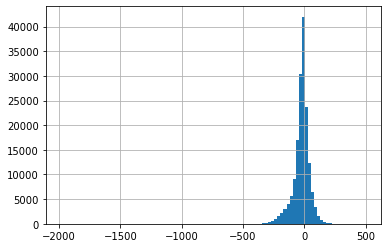

In [35]:
X["Pwr_Std"].hist(bins=100)

In [36]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,Grd_Prod_Pwr_Avg,Amb_WindSpeed_Avg,Amb_Temp_Avg,Nac_Temp_Avg,Rtr_RPM_Avg,Gear_Bear_Temp_Avg,Gen_RPM_Avg,angle_difference,Pwr_Std
Grd_Prod_Pwr_Avg,1.000000,0.977967,0.080337,0.395853,0.895343,0.803416,0.896153,0.275878,-0.104785
Amb_WindSpeed_Avg,0.977967,1.000000,0.132394,0.445356,0.870157,0.810714,0.871524,0.279360,-0.190891
Amb_Temp_Avg,0.080337,0.132394,1.000000,0.871577,0.082513,0.299919,0.082753,0.137425,-0.350920
Nac_Temp_Avg,0.395853,0.445356,0.871577,1.000000,0.352085,0.513489,0.353744,0.212524,-0.382640
Rtr_RPM_Avg,0.895343,0.870157,0.082513,0.352085,1.000000,0.826359,0.999746,0.255907,-0.023252
Gear_Bear_Temp_Avg,0.803416,0.810714,0.299919,0.513489,0.826359,1.000000,0.827375,0.249917,-0.144063
Gen_RPM_Avg,0.896153,0.871524,0.082753,0.353744,0.999746,0.827375,1.000000,0.256272,-0.028616
angle_difference,0.275878,0.279360,0.137425,0.212524,0.255907,0.249917,0.256272,1.000000,-0.114463
Pwr_Std,-0.104785,-0.190891,-0.350920,-0.382640,-0.023252,-0.144063,-0.028616,-0.114463,1.000000


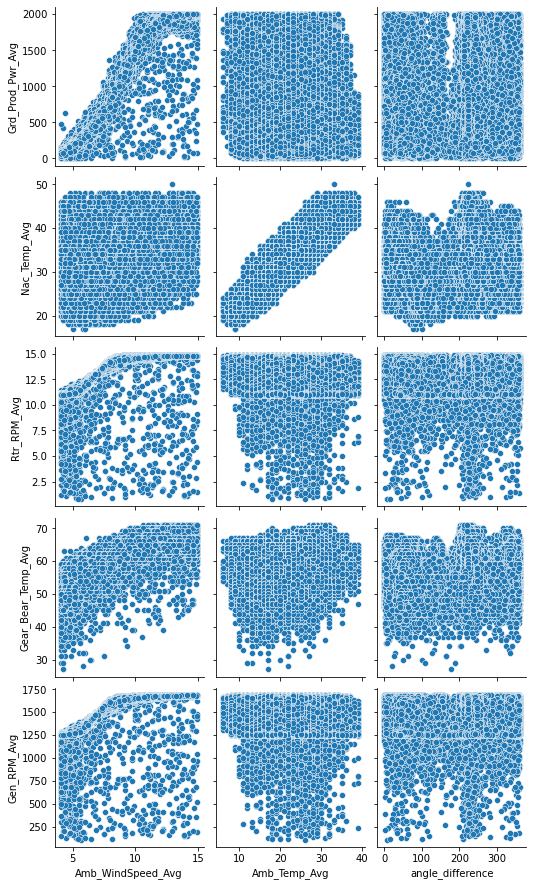

In [37]:
sns.pairplot(X,x_vars=["Amb_WindSpeed_Avg","Amb_Temp_Avg","angle_difference"],y_vars=["Grd_Prod_Pwr_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg",],kind="scatter")
plt.show()

Tu jest ważny bajer tego modelu, dopasowujemy sobie oddzielne modele lasów losowych tłumaczące każdą z tych ["Grd_Prod_Pwr_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg"] zmiennych za pomocą tych 3 zmiennych ["Amb_WindSpeed_Avg","Amb_Temp_Avg","angle_difference"]. Mając te modele regresji możemy analogicznie jak na SARze policzyć wtedy rezydua tych modeli, po prostu odejmując wartość przewidywaną na zbiorze treningowych do wartości prawdziwej na treningowym. Modele trzeba zapamiętać, będą używane w predykcji.

In [38]:
x = X[["Amb_WindSpeed_Avg","Amb_Temp_Avg","angle_difference"]]
X_res = X.copy()
X_res = X_res.drop(columns=["Amb_WindSpeed_Avg","Amb_Temp_Avg","angle_difference"])
models = list()
for l in ["Grd_Prod_Pwr_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg"]:
    y = X[l]
    regr = RandomForestRegressor(max_depth=3, random_state=0)
    regr.fit(x, y)
    X_res[l] = y - regr.predict(x)
    models.append(regr)
    print(regr.score(x,y))

0.9763228613630306
0.7930865257740737
0.8876996762914294
0.7414259592988659
0.8915713581517604


Po miarach R^2 możemy uznać, że nienajgorzej dopasowywują się te modele.

In [39]:
models

[RandomForestRegressor(max_depth=3, random_state=0),
 RandomForestRegressor(max_depth=3, random_state=0),
 RandomForestRegressor(max_depth=3, random_state=0),
 RandomForestRegressor(max_depth=3, random_state=0),
 RandomForestRegressor(max_depth=3, random_state=0)]

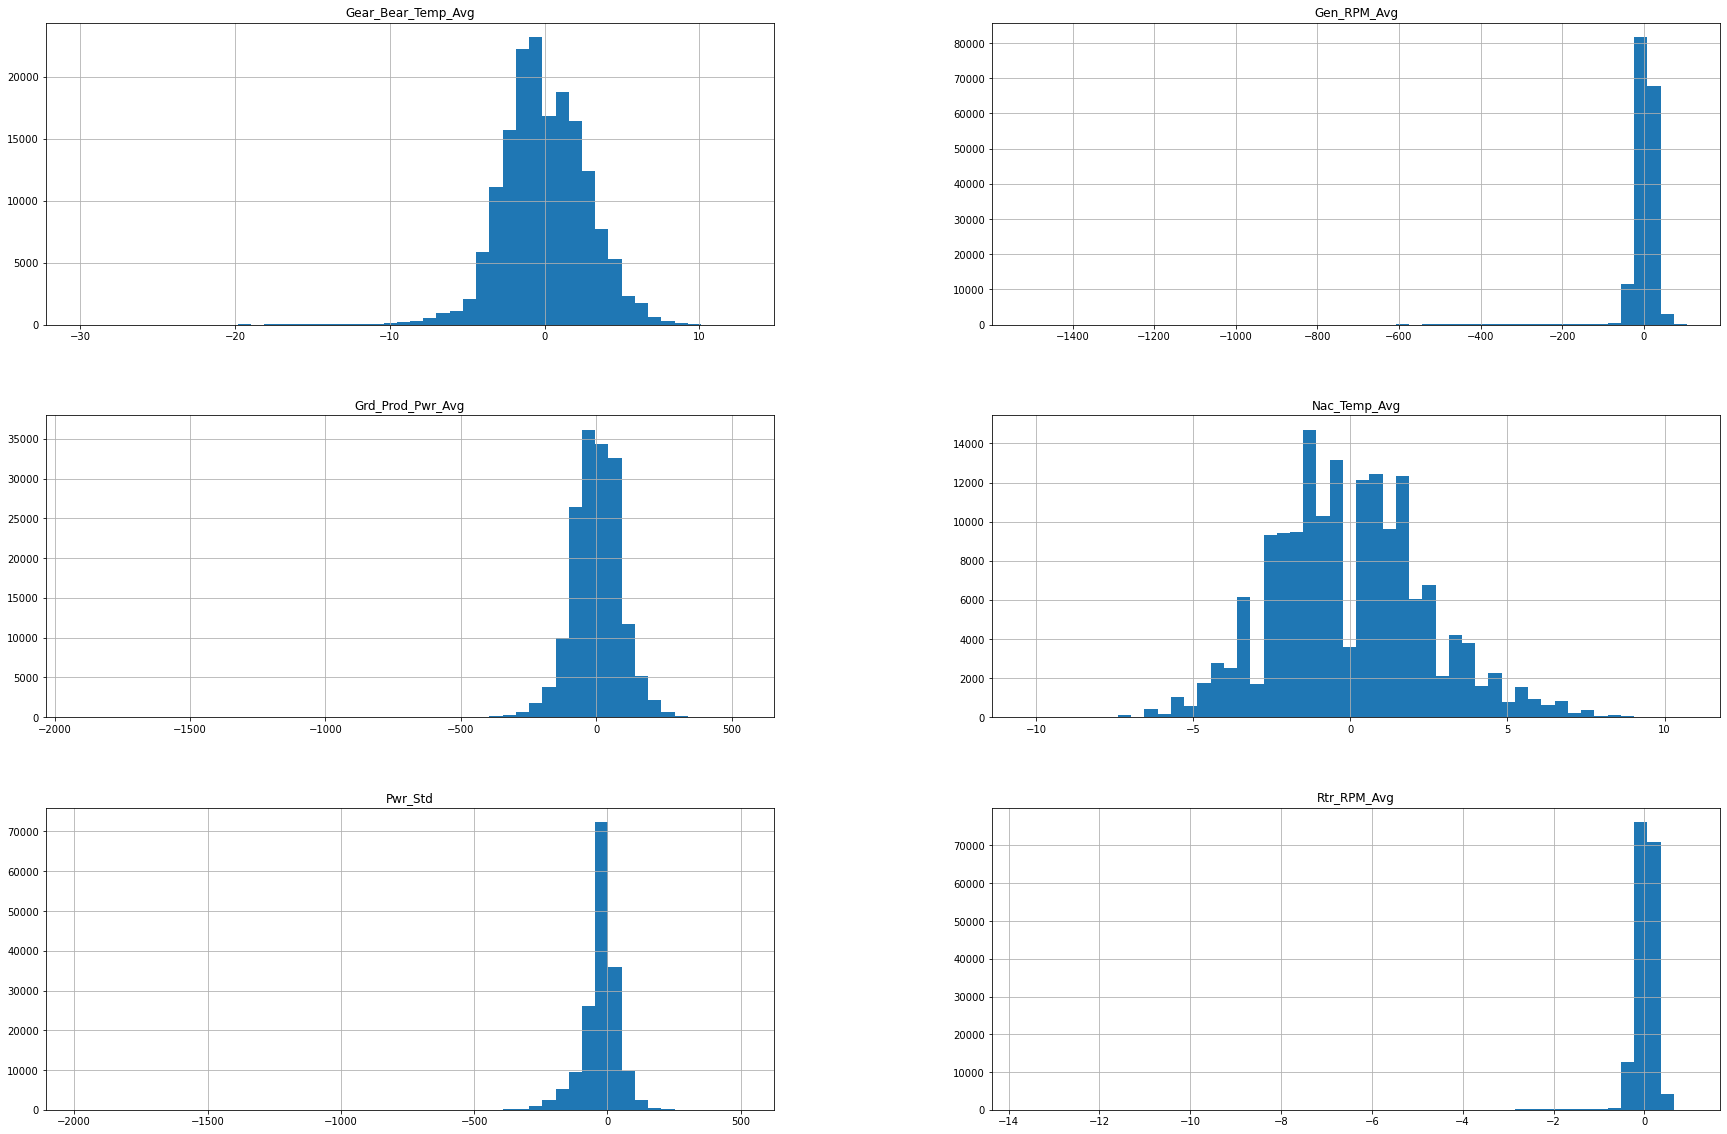

In [40]:
X_res.hist(bins=50,figsize=(30,20))
plt.show()

Histogramy tych rezyduów też są fajne całkiem, rozkładają się dookoła zera, trzeba je tylko wystandaryzować i zapamiętać odchylenia, będą później używane w predykcji.

In [41]:
X_res_std=X_res.apply(lambda x: x/np.std(x),axis=0)

In [42]:
stds = X_res.apply(lambda x: np.std(x),axis=0)
stds

Grd_Prod_Pwr_Avg      99.017691
Nac_Temp_Avg           2.459079
Rtr_RPM_Avg            0.521320
Gear_Bear_Temp_Avg     2.706657
Gen_RPM_Avg           57.713909
Pwr_Std               81.735353
dtype: float64

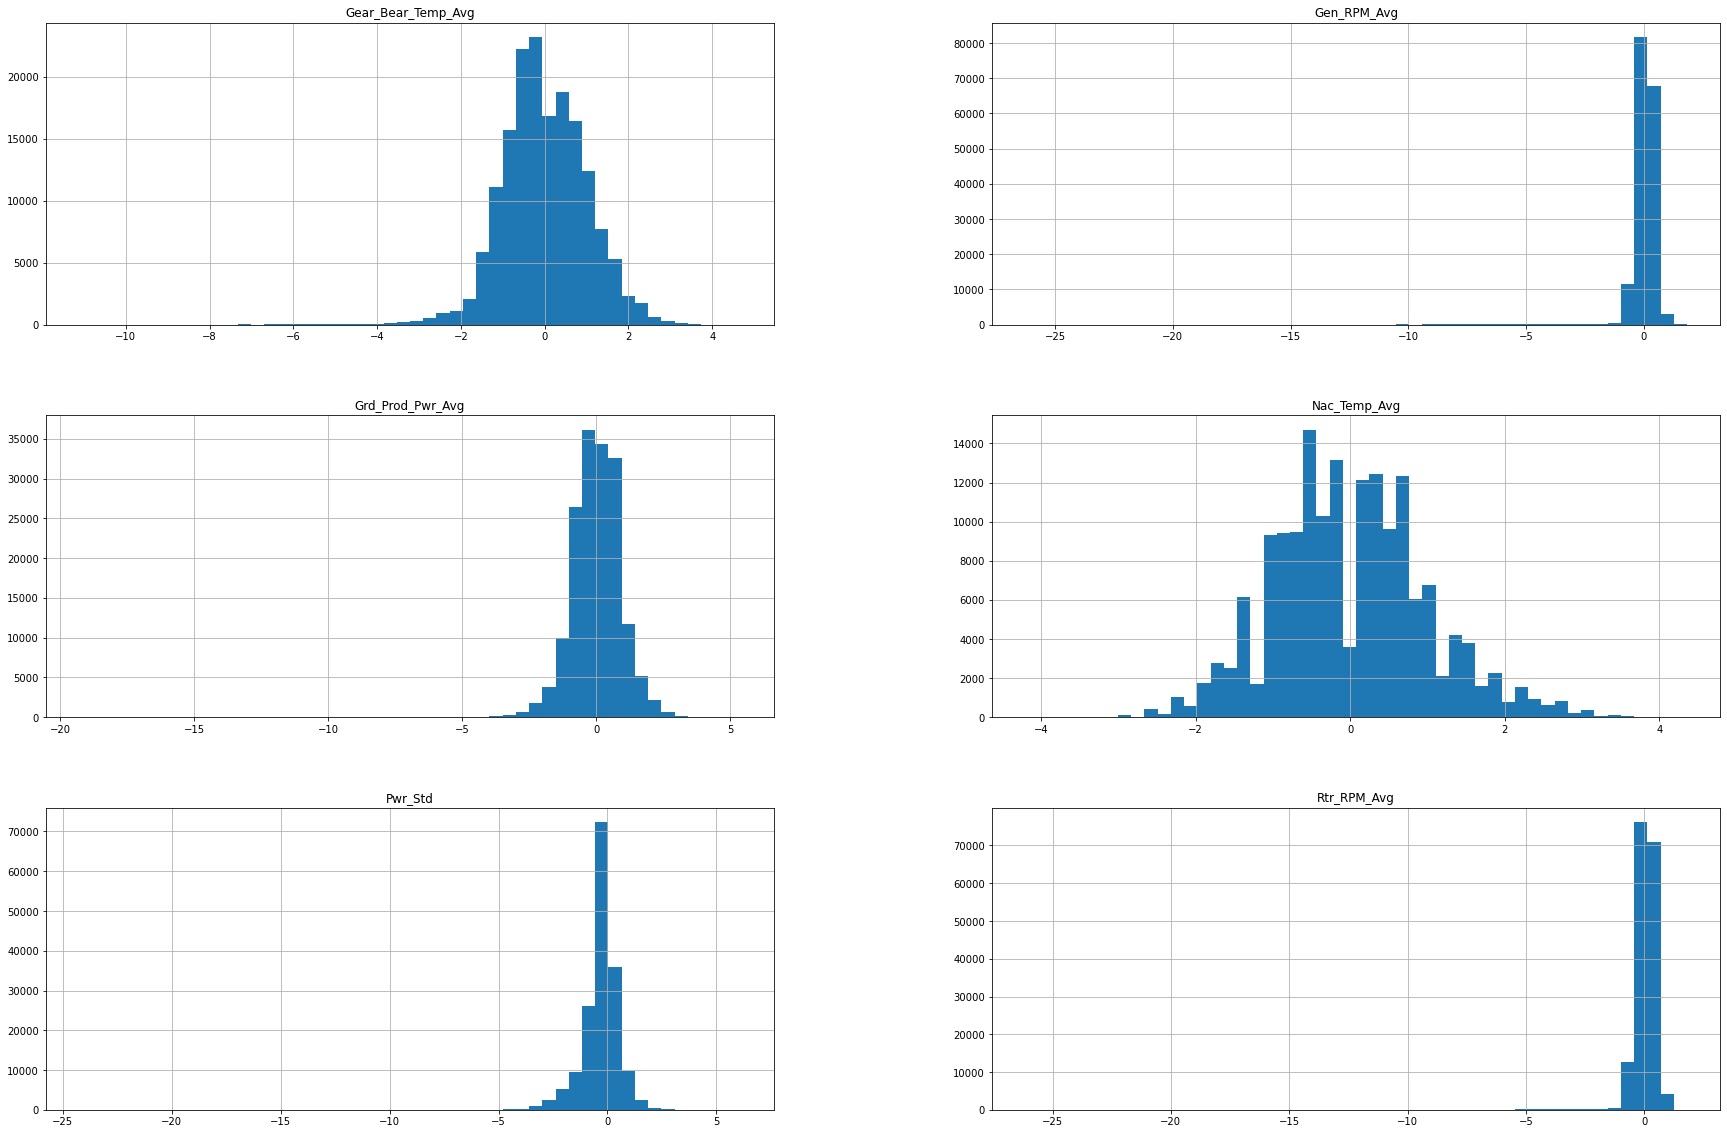

In [43]:
X_res_std.hist(bins=50,figsize=(30,20))
plt.show()

Teraz chcemy pogrupować te obserwacje na podstawie ich rezyduów. Użyjemy do tego Kmeans. Liczbę klastrów znajdziemy za pomocą metody łokcia.

In [44]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

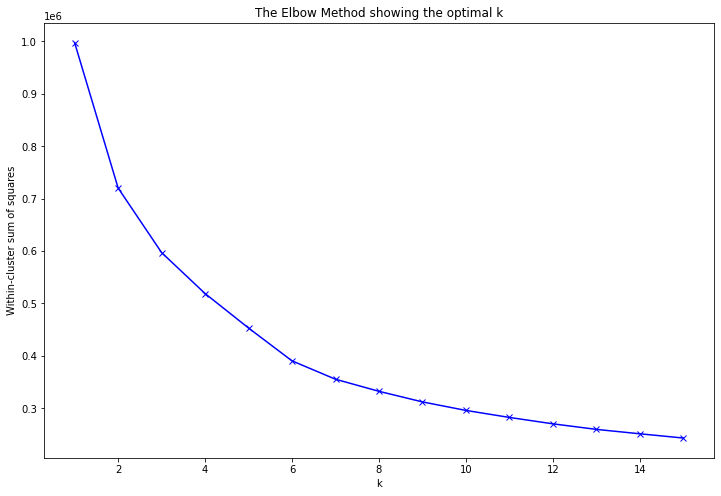

In [45]:
wcss_vec = count_wcss_scores(X_res_std, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
f = plt.figure(figsize=(12, 8))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Optymalnie wychodzi jakieś 6 klastrów, potem się dobrze reszta dopasowywyje dla takiej liczby.

Robię swoją funkcję gamma bo ta pythonowa jest beznadziejna, kto podaje jako skalę 1/beta, to trzeba się rozpędzić i łbem w ścianę trafić jak się tak robi.

In [46]:
def gamma_density(x,alfa,beta):
    return gamma.pdf(x,a=alfa,scale=1/beta)

Dzielimy tutaj obserwacje na 6 grup, trzeba zapamiętać ten model, bo potem nowe obserwacje będziemy chcieli przydzielać do odpowiednich klastrów.

In [47]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X_res_std)

In [48]:
labels=kmeans.labels_

Tutaj kolejny ważny bajer, jak już podzieliliśmy obserwacje na 6 grup to dla każdej z nich dopasowywujemy rozkład gamma i parametry. Zapisujemy je w oddzielnej tabelce dla każdej grupy. Dopasowywanie gammy się wydaje najlepsze, pewnie jakby poczyścić te dane to byłoby lepiej ale kto wie w sumie.

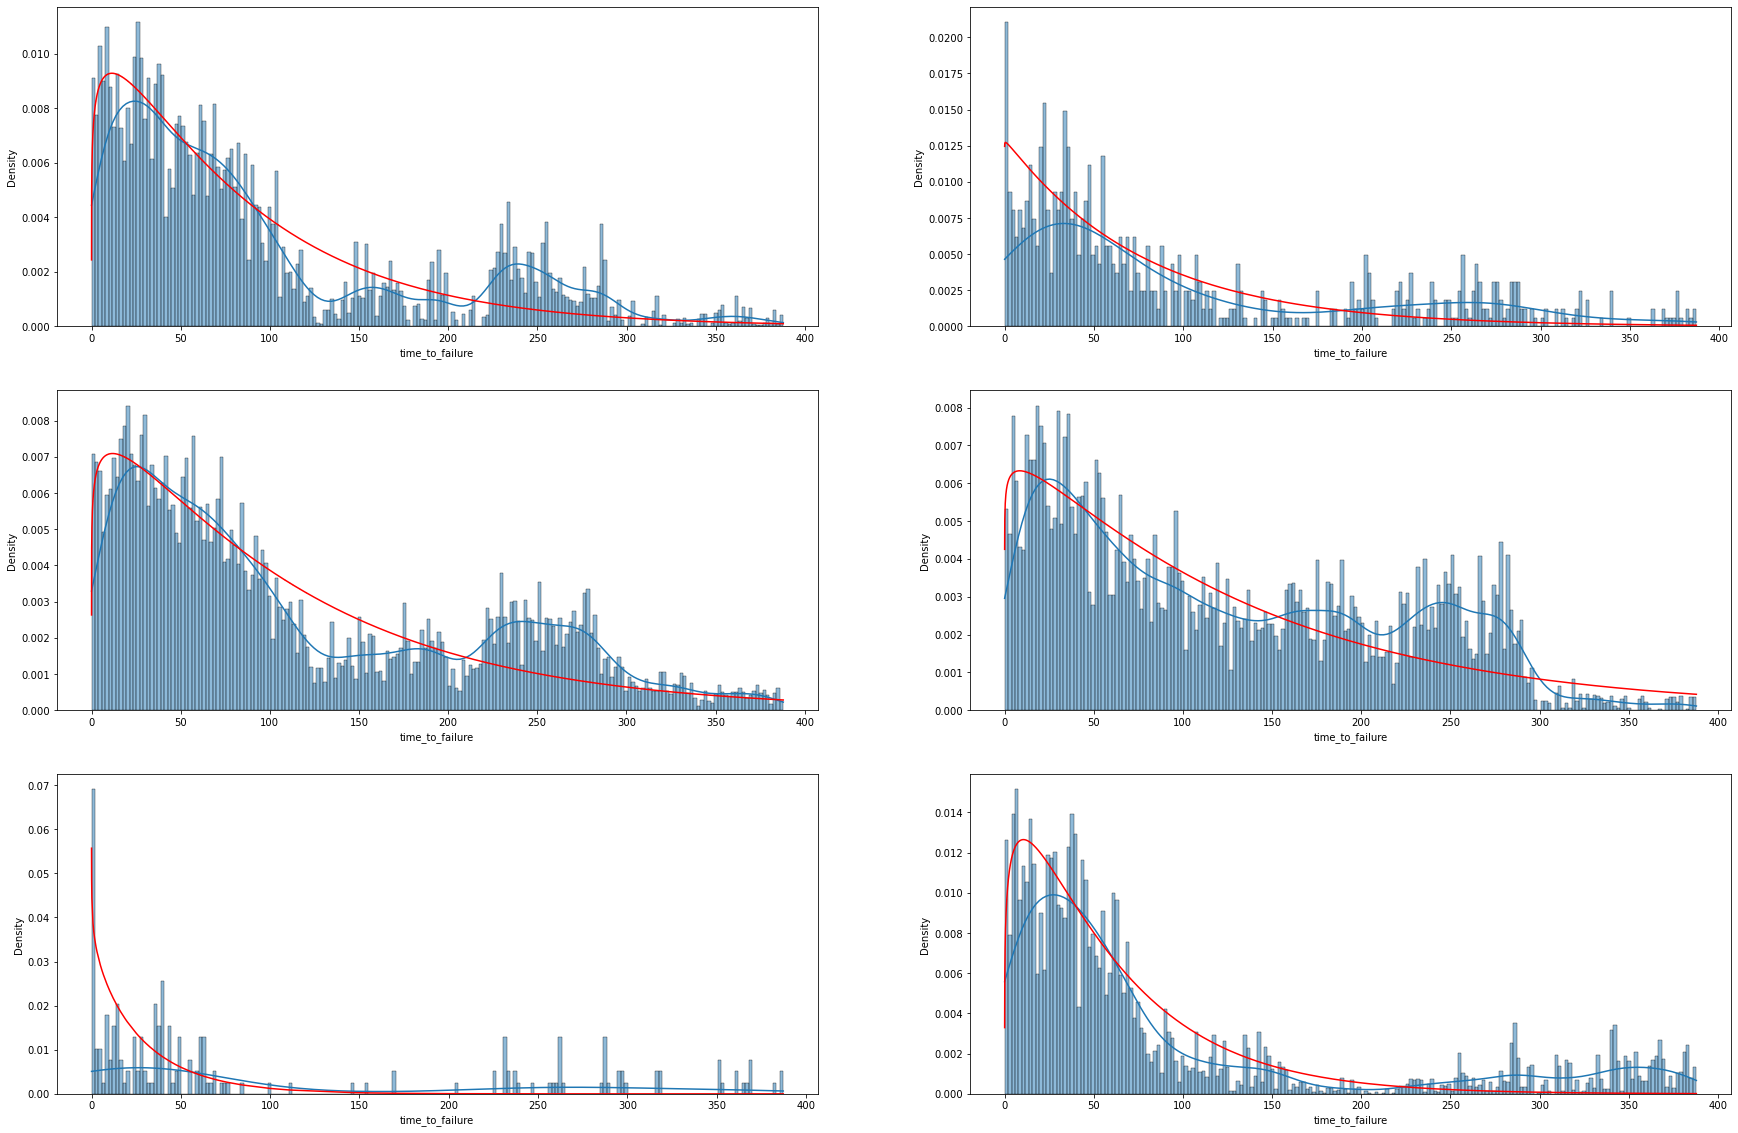

In [49]:
fig,axes = plt.subplots(nrows=3,ncols=2,figsize=(30,20))
params=pd.DataFrame(columns=["alfa","beta"])
for j in range(2):
    for i in range(3):
        Y_ij=Y[labels==i+j*3]/(6*24)
        kde = KD(kernel='gaussian', bandwidth=0.75).fit(np.array(Y_ij).reshape(-1, 1))
        probs=Y_ij.apply(lambda y:np.exp(kde.score_samples(np.array(y).reshape(-1, 1))))
        popt_gamma, pcov_gamma = curve_fit(gamma_density, xdata=Y_ij, ydata=probs)
        prob_gamma=gamma_density(np.sort(Y_ij),popt_gamma[0],popt_gamma[1])
        params.loc[i+j*3,"alfa"]=popt_gamma[0]
        params.loc[i+j*3,"beta"]=popt_gamma[1]
        sns.histplot(Y_ij,bins=200,ax=axes[i,j],kde=True,stat="density")
        sns.lineplot(x=np.sort(Y_ij),y=prob_gamma,color='red',ax=axes[i,j])
plt.show()

In [50]:
params

,alfa,beta
0,1.15341,0.0134451
1,1.11346,0.00962615
2,0.913722,0.0305289
3,1.00622,0.0131725
4,1.06617,0.00781694
5,1.20905,0.0198041


To chyba porzucony pomysł.

In [51]:
#par = params.reset_index()
#par.columns=["in","alfa","beta"]
#par

In [52]:
#parameters = pd.DataFrame({"division":division}).merge(par, left_on="division", right_on="in",how="left")

In [53]:
#parameters = parameters.drop(columns=["in","division"])
#parameters

In [54]:
#mod_alfa = RandomForestRegressor(max_depth=3, random_state=0)
#mod_alfa.fit(X_res_std,parameters["alfa"])
#mod_alfa.score(X_res_std,parameters["alfa"])

In [55]:
#mod_beta = RandomForestRegressor(max_depth=3, random_state=0)
#mod_beta.fit(X_res_std,parameters["beta"])
#mod_beta.score(X_res_std,parameters["beta"])

Tutaj się kończy ten bękart.

Tutaj mamy 2 funkcje do tego indeksu zdrowia. HealthIndeks w zasadzie tylko skleja nam odpowiednio obserwacje, robi nowe zmienne takie jak dla zbioru treningowego, cośtam czyści i uruchamia HI na każdym wierszu. To w zasadzie HI jest tutaj ważniejsza ona liczy wszystko. I tak po kolei:
+ Jeśli wiatr jest chujowy to nie liczymy i zrwacamy 0 z komunikatem, że się nie da
+ Liczymy rezydua nowej obserwacji na tych lasach losowych
+ Liczymy wystandaryzowany power na podstawie power curve
+ Standaryzujemy to co otrzymaliśmy w 2 poprzednich punktach tymi stds
+ Liczymy na podstawie division (u nas kmeans ale dla ogólnego przypadku robiłem) do której grupy trafia obserwacja
+ Na koniec możemy wybrać 2 różne indeksy zdrowia, jesli podaliśmy sensowne days to policzymy pstwo P(awaria nastąpi w mniej niż days)=P(X<days) gdzie X~Gamma(alfa,beta). W przeciwnym przypadku zwróci nam kwantyl rozkładu Gamma(alfa,beta) rzędu q, czyli w interpretacji będzie to w przeciągu ilu dni turbina zrobi fikoła z pstwem q, taki prawostronny przedział ufności.
+ Zwraca tupla z indeksem i informacją jakiego typu jest

In [56]:
def HI(observation,stds,pc,models,division,params,q=0.95,days=None):
    '''
    observation - pojedyncza obserwacja z połączonej ramki danych
    stds - wektor odchyleń standardowych, który wcześniej powinniśmy zapamiętać
    pc - nasza funkcja power curve, ta ciągła
    models - nasze 5 lasów losowych, które wcześniej powinniśmy zapamiętać
    division - model podziału danych na grupy, ważne, żeby miał .predict w opcjach
    params - nasze przewidywane alfa i beta dla każdego klastru
    q - rząd kwantyla z zakresu (0,1)
    days - liczba dni, może być float byle >0
    '''
    if observation["Amb_WindSpeed_Avg"]<4 or observation["Amb_WindSpeed_Avg"]>15: return (0,"unable to calculate")
    observation_res = pd.DataFrame()
    predictors = observation[["Amb_WindSpeed_Avg","Amb_Temp_Avg","angle_difference"]]
    names = ["Grd_Prod_Pwr_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg"]
    for l in range(5):
        observation_res[names[l]] = observation[names[l]] - models[l].predict(np.array(predictors).reshape(1,-1))
    observation_res["Pwr_Std"] = observation["Grd_Prod_Pwr_Avg"] - pc(observation["Amb_WindSpeed_Avg"])
    observation_res_std = observation_res/stds
    label = division.predict(observation_res_std)[0]
    if days==None:
        return (gamma.ppf(q, a=params.loc[label,"alfa"], scale=1/params.loc[label,"beta"]),"Quantile index")
    else:
        return (gamma.cdf(days, a=params.loc[label,"alfa"], scale=1/params.loc[label,"beta"]),"Probability index")

Ważne żeby do HealthIndex dawać new_signal i new_weather takie z minimum 2 obserwacjami, żeby to były ramki danych, bo ten python nie może pojąć że jeden wiersz to dalej jest ramka danych a nie jakieś series. No za Chiny, nie da się zmienić series na dataframe, a psuje to funkcjonalność. Co za debil to pisał.

In [57]:
def HealthIndex(new_signal,new_weather,stds,pc,models,division,params,q=0.95,days=None):
    signal = new_signal.copy()
    signal["time"] = signal.Timestamp.apply(lambda x:clean_timestamp(x,benchmark_date))
    signal["period"] = signal.time.apply(lambda x:int(np.floor(x/600)))
    
    weather = new_weather.copy()
    weather["time"] = weather.Timestamp.apply(lambda x:clean_timestamp(x,benchmark_date))
    weather["period"] = weather.time.apply(lambda x:int(np.floor(x/600)))
    
    new_x = signal.merge(weather,on=["period"])
    new_x["angle_difference"]=(new_x["Nac_Direction_Avg"]-new_x["Avg_Winddirection2"])%360
    new_x = new_x[["Grd_Prod_Pwr_Avg", "Amb_WindSpeed_Avg", "Amb_Temp_Avg", "Nac_Temp_Avg", "Rtr_RPM_Avg", "Gear_Bear_Temp_Avg", "Gen_RPM_Avg","angle_difference"]]
    
    return new_x.apply(lambda x: HI(x,stds,pc,models,division,params,q=q,days=days),axis=1)

In [59]:
metmast_test = pd.read_csv("wind-farm-1-metmast-training.csv",sep=";")
signals_test = pd.read_csv("wind-farm-1-signals-training.csv",sep=";")

Przykład jak trzeba podawać dane wejściowe do HealthIndex.

In [60]:
HealthIndex(signals_test.iloc[0:10,:],metmast_test.iloc[0:10,:],stds,power_curve2,models,kmeans,params,q=0.95)

0    (399.4736918433397, Quantile index)
1               (0, unable to calculate)
2               (0, unable to calculate)
3    (333.6707214442715, Quantile index)
4    (333.6707214442715, Quantile index)
5    (333.6707214442715, Quantile index)
6    (333.6707214442715, Quantile index)
7               (0, unable to calculate)
8               (0, unable to calculate)
9    (399.4736918433397, Quantile index)
dtype: object

In [61]:
HealthIndex(signals_test.iloc[0:10,:],metmast_test.iloc[0:10,:],stds,power_curve2,models,kmeans,params,q=None,days=200)

0    (0.7700985894162437, Probability index)
1                   (0, unable to calculate)
2                   (0, unable to calculate)
3    (0.8266961600149825, Probability index)
4    (0.8266961600149825, Probability index)
5    (0.8266961600149825, Probability index)
6    (0.8266961600149825, Probability index)
7                   (0, unable to calculate)
8                   (0, unable to calculate)
9    (0.7700985894162437, Probability index)
dtype: object